1. scaled the target variables to get better rmse
2. used newly processed feng data final

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data
import pandas as pd
import numpy as np
import ast
from numpy import mean

# visualization
import matplotlib.pyplot as plt

# chosen models
from xgboost import XGBRegressor

# data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# model training selection
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RepeatedStratifiedKFold

## model evaluation metrics
from collections import Counter
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse

# important cols
from xgboost import plot_importance
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
df = pd.read_csv('../data/feature_engineering/combined_feng_final.csv', index_col=0)
df.shape

(2197, 4628)

### get all top features based on pca

In [3]:
with open('../nb_feng/high_var_org_col_final.txt', 'r') as reader:
    high_var_org_col = reader.read()

In [4]:
high_var_org_col = ast.literal_eval(high_var_org_col)
len(high_var_org_col)

1940

In [5]:
df1940 = df[high_var_org_col]

### split data

In [6]:
# get data
X = df1940
y = df['total_funding_amount_usd']

In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### scale numerical features 
*also scale output feature but note data leakage, split data first then standard scale it on train data, then also use same scaler to transform test data*

In [8]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [9]:
scaler2 = MinMaxScaler().fit(np.array(y_train).reshape(-1, 1))
y_train_scaled = scaler2.transform(np.array(y_train).reshape(-1, 1))

## machine learning

In [10]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=123)

In [11]:
xgb.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=12, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [12]:
X_test_scaled = scaler.transform(X_test)

In [13]:
pred = xgb.predict(X_test_scaled)

In [14]:
y_test_scaled = scaler2.transform(np.array(y_test).reshape(-1, 1))

In [15]:
rmse = np.sqrt(mse(y_test_scaled, pred))
rmse

0.04383948223288443

rmse was extremely high (`1046856`) because the range of y was high. After scaling y to a range between 0 and 1, we receive a good rmse score.

### check prediction values

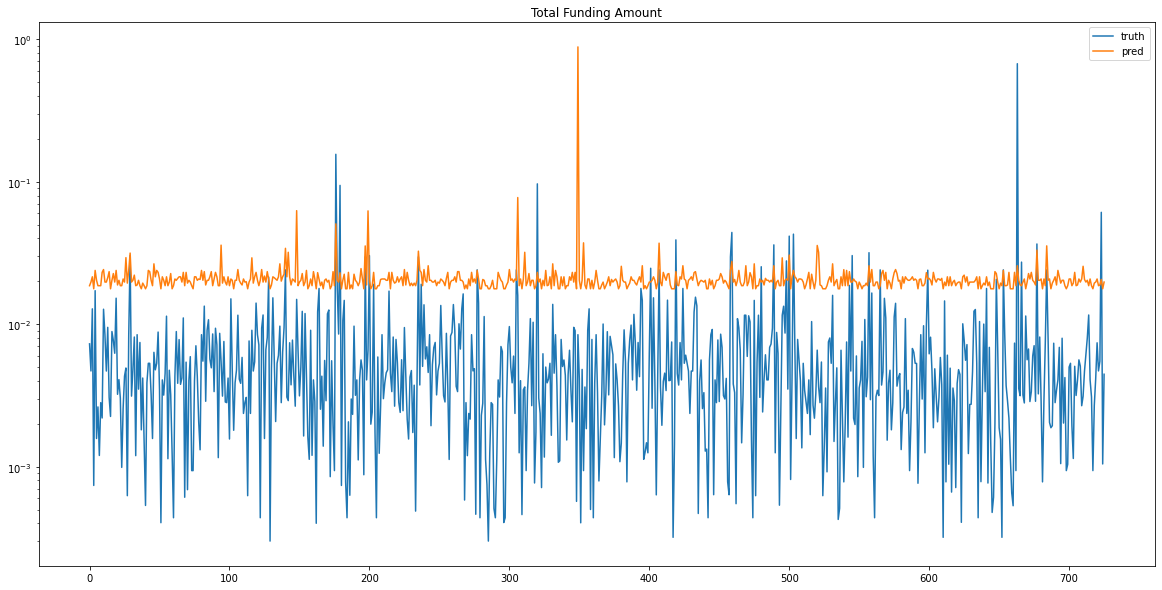

In [16]:
x_ax = range(len(y_test))
plt.figure(figsize=(20,10))
plt.plot(x_ax, y_test_scaled, label="truth")
plt.plot(x_ax, pred, label="pred")
plt.title("Total Funding Amount")
plt.yscale('log')
plt.legend()
plt.show()

<span style="color:red">
however, when looking at the plot, the prediction actually doesn't look that good, also, it seems that the prediction always started from a base value while the actual truth value fluctuates much more and is at a much lower range...?

### xgb feature importance

In [17]:
important_features_dict = xgb.get_booster().get_score(importance_type='weight')
important_cols = list(important_features_dict.keys())

In [18]:
len(important_cols)

31

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

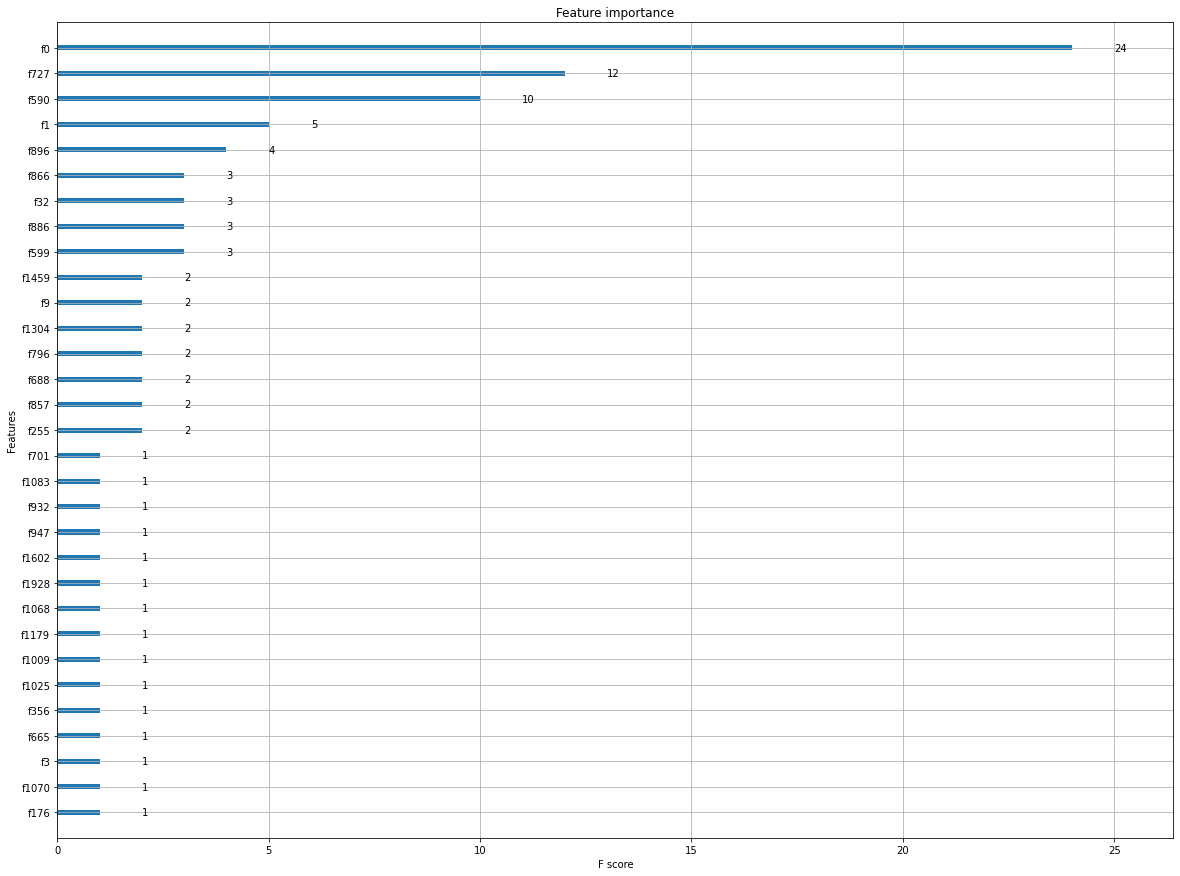

In [20]:
plt.rcParams["figure.figsize"] = (20, 15)
plot_importance(xgb)

In [29]:
cols_idx = [int(idx[1:]) for idx in important_cols]
df.columns[cols_idx]

Index(['pozuelo', 'versailles', 'albert armengol', 'number_of_founders',
       'raleigh', 'number_of_funding_rounds', 'falls church', 'acton capital',
       'surrey', '360 tianqing', 'aixiang capital', 'carmel',
       'arwen elys dayton', 'trend_score_30', 'data and analytics',
       'simi valley', 'adeo', 'boyuan haoxiang', 'new england',
       'chi & partners', 'iceland', 'apex ventures', 'anglia capital group',
       'beatriz del rio', 'artis ventures (av)', 'eyal shaked',
       'craft ventures', 'alta partners', 'almaz capital', 'at&t',
       'the netherlands'],
      dtype='object')

<span style="color:red">
not sure what the col names mean...? assuming its the index for the cols?

## explain predictions with shap

In [30]:
explainer = shap.TreeExplainer(xgb)

### visualize a single prediction

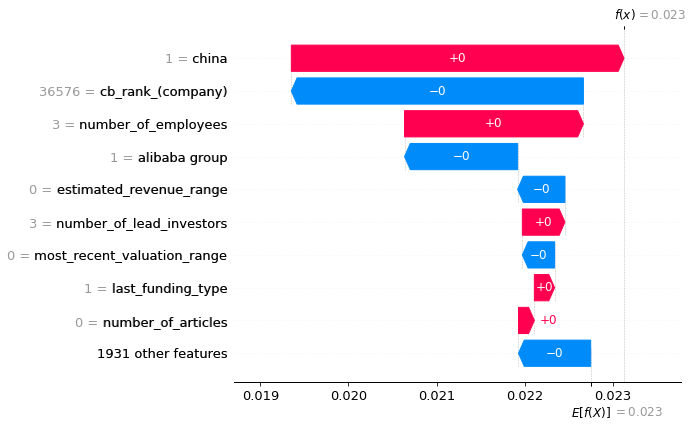

In [31]:
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

In [32]:
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

### bar chart of mean importance

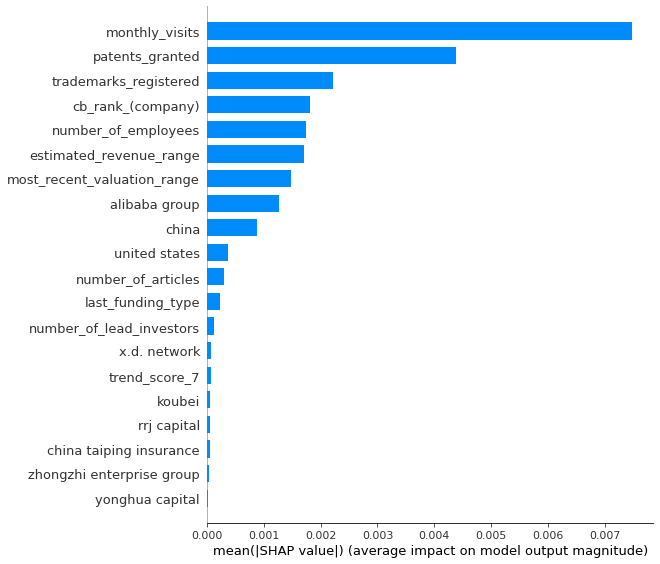

In [34]:
shap.summary_plot(shap_values, X, plot_type="bar")

### shap summary plot

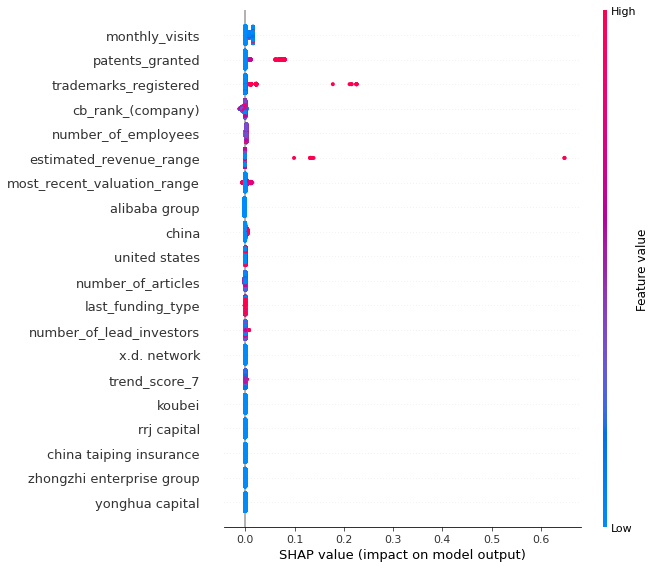

In [37]:
shap.summary_plot(shap_values, X)

<span style="color:red">
what happened to the summary plot??? shouldnt it be like beeswarm?

also, i checked that for the data and location after dropping the ones we, China (332), EU (572), US (966), null (327)

### shap dependence plots

In [40]:
shap_cols = [# from waterfall explainer
             'china', 'cb_rank_(company)', 'number_of_employees', 'alibaba group', 'estimated_revenue_range',
             'number_of_lead_investors', 'most_recent_valuation_range', 'last_funding_type', 'number_of_articles'
             # from mean importance
             'monthly_visits', 'patents_granted', 'trademarks_registered',
             #'cb_rank_(company)', 'number_of_employees', 'estimated_revenue_range', 
             #'alibaba group' ,'china', 'number_of_articles', 'last_funding_type', 'number_of_lead_investors'
             'most_recent_valuation_range', 'united states', 'x.d. network', 'trend_score_7',
             'koubei', 'rrj capital', 'china taiping insurance', 'zhongzhi enterprise group', 'yonghua capital']

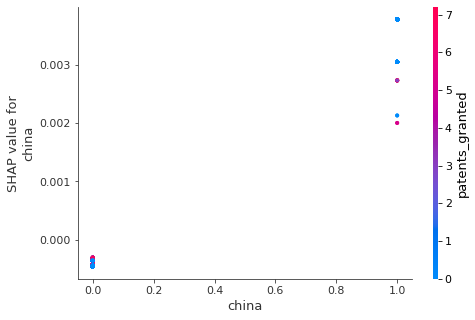

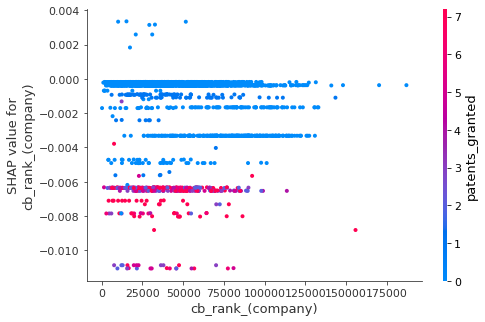

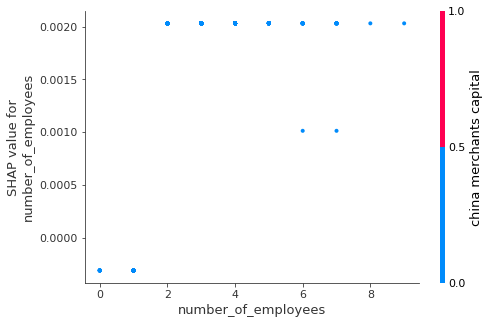

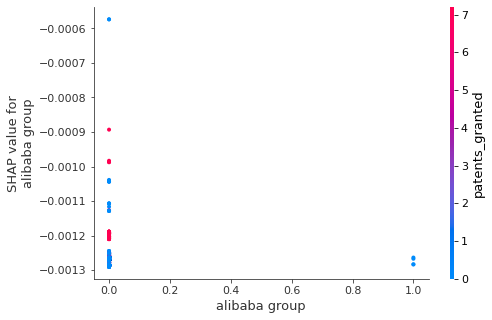

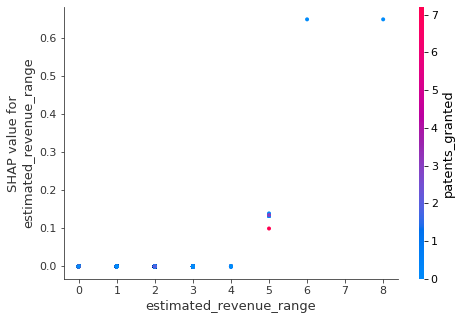

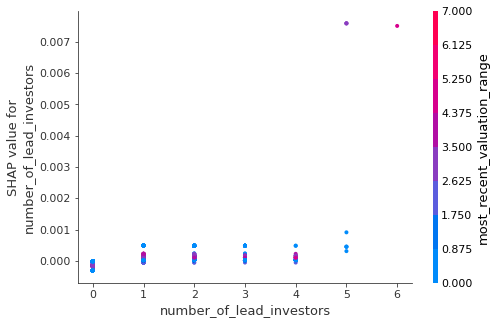

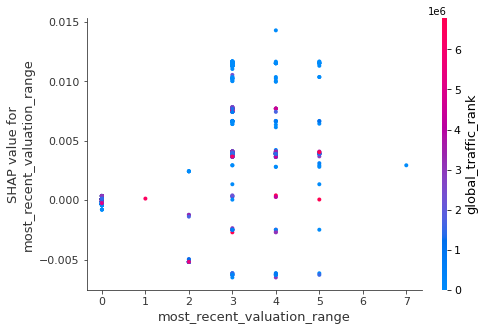

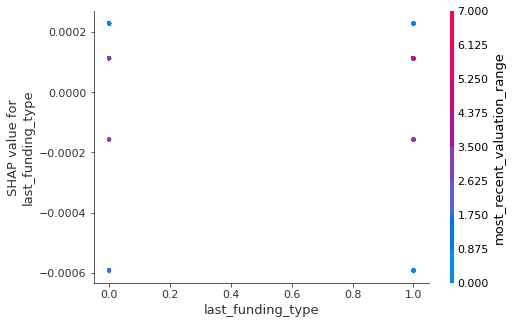

ValueError: Could not find feature named: number_of_articlesmonthly_visits

In [41]:
for name in shap_cols:
    shap.dependence_plot(name, shap_values, X)

<span style="color:red">
also!! the `female_led` column was not picked up!!!